In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data.synthetic import Generator
from utils import helper_functions as hf

In [2]:
n = 500
d = [8, 10]
q = 5
min_len = 15
max_len = 20
max_time = 21

In [3]:
model = Generator(n, d, q, min_len, max_len, max_time)

In [4]:
d = model.metadata['d']
n = model.metadata['n']
t = model.attributes['t']
q_actual = model.metadata['q']
w_actual = model.params['w']
v_actual = model.params['v']
omega_actual = model.params['omega']
mu_actual = model.params['mu']
sigma2_actual = model.params['sigma2']

In [5]:
x_actual, y_actual = model.generate_data(gaussian=True)

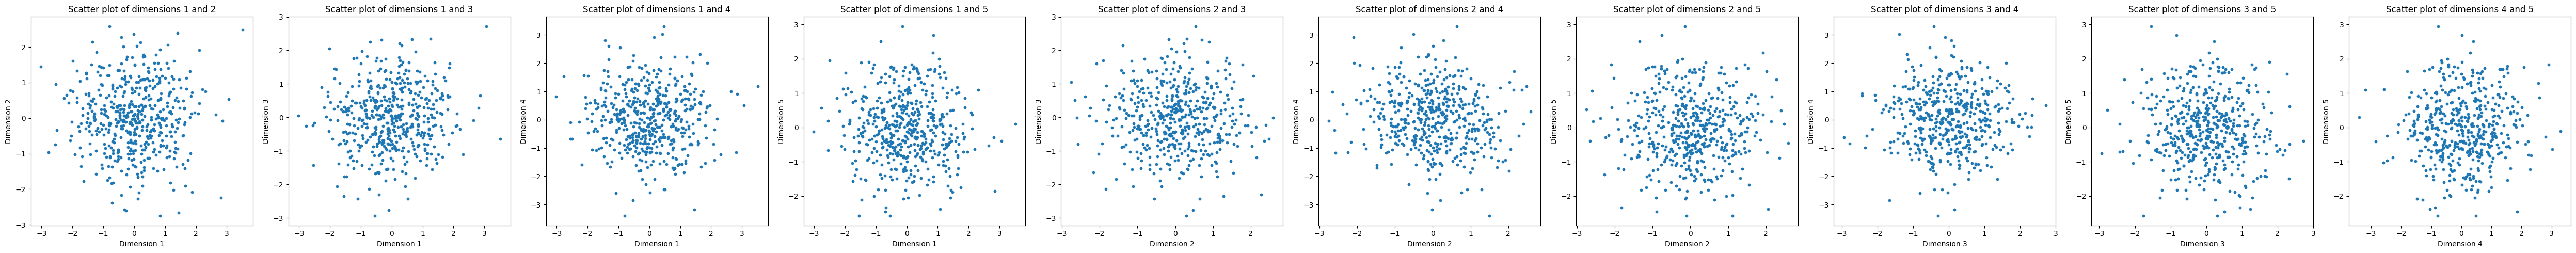

In [6]:
hf.plot_scatter_pairs_latent(x_actual)

In [7]:
mae_results = []
marginal_likelihood_results = []
mae_std_results = []
marginal_likelihood_std_results = []
q_values = range(1, 10)
n_folds = 5
y_actual_np = np.array(y_actual, dtype=object)

for q in q_values:
    print('q=', q)
    mae_q = []
    marginal_likelihood_q = []

    for cv in range(n_folds):
        print('q=', q, '& cv fold is', cv)
        # Initialize the parameters
        mu_init, omega_init, w_init, v_init, sigma2_init = hf.random_params(d, q, seed=None)

        # Fit the model and get the optimized parameters
        w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, training_history = hf.fit(
            y_actual, w_init, v_init, mu_init, omega_init, sigma2_init, t, n_epochs=100, history=True)

        # Compute the posterior moments
        posterior_mean, _, posterior_variance = hf.posterior_moments(
            y_actual, w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, t)

        # Reconstruct "x"
        x_recon = np.zeros((n, q))
        for i in range(n):
            rnd = np.random.default_rng()
            x_recon[i] = rnd.multivariate_normal(mean=posterior_mean[i], cov=posterior_variance[i])

        # Reconstruct "y"
        y_recon = hf.decode(x_recon, w_opt, v_opt, mu_opt, omega_opt, sigma2_opt, t, seed=None, noise=True)
        y_recon_np = np.array(y_recon, dtype=object)

        # Compute the MAE
        mae_total, _ = hf.mae(y_actual_np, y_recon_np)

        # Append the results
        mae_q.append(mae_total)
        marginal_likelihood_q.append(training_history[-1])

    # Compute the average MAE and marginal likelihood for "q" and append to the results
    mae_results.append(np.mean(mae_q))
    marginal_likelihood_results.append(np.mean(marginal_likelihood_q))
    mae_std_results.append(np.std(mae_q))
    marginal_likelihood_std_results.append(np.std(marginal_likelihood_q))


q= 1
q= 1 & cv fold is 0
q= 1 & cv fold is 1
q= 1 & cv fold is 2
q= 1 & cv fold is 3
q= 1 & cv fold is 4
q= 2
q= 2 & cv fold is 0
q= 2 & cv fold is 1
q= 2 & cv fold is 2
q= 2 & cv fold is 3
q= 2 & cv fold is 4
q= 3
q= 3 & cv fold is 0
q= 3 & cv fold is 1
q= 3 & cv fold is 2
q= 3 & cv fold is 3
q= 3 & cv fold is 4
q= 4
q= 4 & cv fold is 0
q= 4 & cv fold is 1
q= 4 & cv fold is 2
q= 4 & cv fold is 3
q= 4 & cv fold is 4
q= 5
q= 5 & cv fold is 0
q= 5 & cv fold is 1
q= 5 & cv fold is 2
q= 5 & cv fold is 3
q= 5 & cv fold is 4
q= 6
q= 6 & cv fold is 0
q= 6 & cv fold is 1
q= 6 & cv fold is 2
q= 6 & cv fold is 3
q= 6 & cv fold is 4
q= 7
q= 7 & cv fold is 0
q= 7 & cv fold is 1
q= 7 & cv fold is 2
q= 7 & cv fold is 3
q= 7 & cv fold is 4
q= 8
q= 8 & cv fold is 0
q= 8 & cv fold is 1
q= 8 & cv fold is 2
q= 8 & cv fold is 3
q= 8 & cv fold is 4
q= 9
q= 9 & cv fold is 0
q= 9 & cv fold is 1
q= 9 & cv fold is 2
q= 9 & cv fold is 3
q= 9 & cv fold is 4


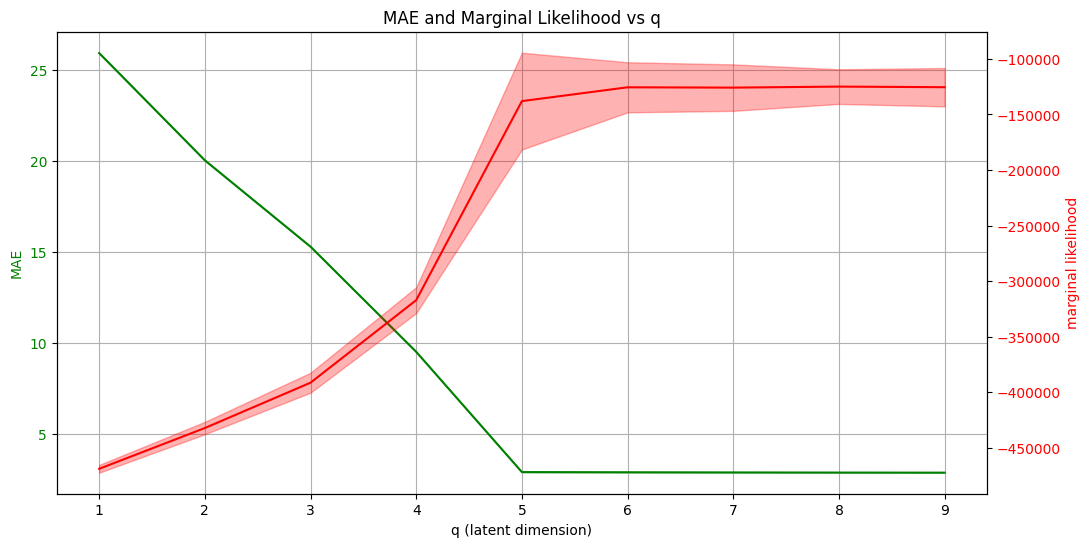

In [8]:
# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the MAE results on the first y-axis
ax1.plot(q_values, mae_results, linestyle='solid', color='green', label='MAE')
ax1.fill_between(q_values, np.array(mae_results) - np.array(mae_std_results), np.array(mae_results) + np.array(mae_std_results), color='green', alpha=0.3)
ax1.set_xlabel('q (latent dimension)')
ax1.set_ylabel('MAE', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True)

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the marginal likelihood results on the second y-axis
ax2.plot(q_values, marginal_likelihood_results, linestyle='solid', color='red', label='marginal likelihood')
ax2.fill_between(q_values, np.array(marginal_likelihood_results) - np.array(marginal_likelihood_std_results), np.array(marginal_likelihood_results) + np.array(marginal_likelihood_std_results), color='red', alpha=0.3)
ax2.set_ylabel('marginal likelihood', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add a title
plt.title('MAE and Marginal Likelihood vs q')

# Show the plot
plt.show()